<a href="https://colab.research.google.com/github/gravity0717/Capstone/blob/main/MuitiCNN_MU_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd 
import json 
import tarfile 
import torch 
from torch.utils.data import Dataset
import math
from PIL import Image
from google.colab import drive 
drive.mount('/content/drive')
import math

Mounted at /content/drive


**사용할 csv 파일에 대해서**

In [ ]:
df =pd.read_csv("/content/drive/MyDrive/캡스톤/label_and_path_withoutNaN")


In [ ]:
from sklearn.metrics import mean_squared_error
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')


**데이터 정의**

1.MU

2.MU-normalize : groundtruth 를 0 to 1 으로 정규화 -> 채택


In [ ]:
from PIL import Image 
import glob
from torch.utils.data.dataset import Dataset
import numpy as np 
from torchvision import transforms
import os 
class MU(Dataset):
  def __init__(self,csv_path):
    self.to_tensor=transforms.ToTensor()
    # Read the csv file 
    self.data_info = pd.read_csv(csv_path,header=None)
    # Read image path 
    self.img_path =  np.asarray(self.data_info.iloc[1:,9])
    # Read the log_view < log_view as label>
    self.label_arr = np.asarray(self.data_info.iloc[1:,8])
    
    
    
    self.transformations = \
            transforms.Compose([transforms.Resize(256),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.ToTensor()])
    
  
        
  def __len__(self):
    return len(self.label_arr)
  # def wait to drop 

  def __getitem__(self,idx):
   #Get image name (actual path where images are )from pandas 
    if self.img_path is not np.nan:
      u=self.img_path[idx] + "/U.jpg" # 상의
      p=self.img_path[idx] + "/P.jpg" # 하의
      s=self.img_path[idx] + "/S.jpg" # 신발
    else: 
      pass 
    # Open Image 
    # 이미지가 경로에 없는 겨우 대비해야 할 것 
    if os.path.isfile(u):
      u_as_img =Image.open(u)
    else :
      u_as_img =Image.new("RGB", (256, 256), (255, 255, 255))
    if os.path.isfile(p):
      p_as_img =Image.open(p)
    else :
      p_as_img =Image.new("RGB", (256, 256), (255, 255, 255))

    if os.path.isfile(s):
      s_as_img =Image.open(s)
    else :
      s_as_img =Image.new("RGB", (256, 256), (255, 255, 255))
    #Img -> to tensor 
    u_as_tensor =self.to_tensor(u_as_img)
    p_as_tensor =self.to_tensor(p_as_img)
    s_as_tensor =self.to_tensor(s_as_img)
    

    _label=torch.tensor(float(self.label_arr[idx]))
    label=torch.reshape(_label,(-1,))
 
    
    return(u_as_tensor,p_as_tensor,s_as_tensor,label)



In [ ]:
from PIL import Image 
import glob
from torch.utils.data.dataset import Dataset
import numpy as np 
from torchvision import transforms
from sklearn.preprocessing import minmax_scale
import os 
class MU_normalized(Dataset):
  def __init__(self,csv_path):
    self.to_tensor=transforms.ToTensor()
    # Read the csv file 
    self.data_info = pd.read_csv(csv_path,header=None)
    # Read image path 
    self.img_path =  np.asarray(self.data_info.iloc[1:,9])
    # Read the log_view < log_view as label>
    self.label_arr =np.asarray(self.data_info.iloc[1:,8])
    self.label_arr=minmax_scale(self.label_arr)
    print(self.label_arr)
    print(self.img_path)
   
    self.transformations = transforms.Compose(
                                [transforms.ToTensor()
                                ,transforms.Resize((256,256)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                ])
    
  
        
  def __len__(self):
    return len(self.label_arr)
  # def wait to drop 

  def __getitem__(self,idx):
   #Get image name (actually path where images are )from pandas 
    if self.img_path is not np.nan:
      u=self.img_path[idx] + "/U.jpg" # 상의
      p=self.img_path[idx] + "/P.jpg" # 하의
      s=self.img_path[idx] + "/S.jpg" # 상의
    else: 
      pass 
    # Open Image 
    
    # 이미지가 경로에 없는 겨우 대비해야 할 것 
    if os.path.exists(u):
      u_as_img =Image.open(u).convert("RGB")
    else :
      u_as_img =Image.new("RGB", (256, 256), (255, 255, 255))
    if os.path.exists(p):
      p_as_img =Image.open(p).convert("RGB")
    else :
      p_as_img =Image.new("RGB", (256, 256), (255, 255, 255))

    if os.path.exists(s):
      s_as_img =Image.open(s).convert("RGB")
    else :
      s_as_img =Image.new("RGB", (256, 256), (255, 255, 255))
    #Transformations  
    u_as_tensor =self.transformations(u_as_img)
    p_as_tensor =self.transformations(p_as_img)
    s_as_tensor =self.transformations(s_as_img)
    

    _label=torch.tensor(float(self.label_arr[idx]))
    label=torch.reshape(_label,(-1,))
 
    
    return(u_as_tensor,p_as_tensor,s_as_tensor,label)



**Model Architecture**

1. VGG16 transfer learning

2. Model_dp : model with dropout

3. Model_no_dp : model without dropout -> 채택 

In [ ]:
'''

transfer learning 


새로 훈련할 데이터가 적지만 original 데이터와 유사할 경우
데이터의 양이 적어 fine-tune (전체 모델에 대해서 backpropagation을 진행하는 것) 은 over-fitting의 위험이 있기에 하지 않습니다.
새로 학습할 데이터는 original 데이터와 유사하기 때문에 이 경우 최종 linear classfier 레이어만 학습을 합니다.

새로 훈련할 데이터가 매우 많으며 original 데이터와 유사할 경우
새로 학습할 데이터의 양이 많다는 것은 over-fitting의 위험이 낮다는 뜻이므로, 전체 레이어에 대해서 fine-tune을 합니다.

새로 훈련할 데이터가 적으며 original 데이터와 다른 경우
데이터의 양이 적기 때문에 최종 단계의 linear classifier 레이어를 학습하는 것이 좋을 것입니다. 반면서 데이터가 서로 다르기 때문에 거의 마지막부분 (the top of the network)만 학습하는 것은 좋지 않습니다. 서로 상충이 되는데.. 이 경우에는 네트워크 초기 부분 어딘가 activation 이후에 특정 레이어를 학습시키는게 좋습니다.

새로 훈련할 데이터가 많지만 original 데이터와와 다른 경우
데이터가 많기 때문에 아예 새로운 ConvNet을 만들수도 있지만, 실적적으로 transfer learning이 더 효율이 좋습니다. 전체 네트워크에 대해서 fine-tune을 해도 됩니다.

'''

from torchvision import models

model_pt=models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')


for p in model_pt.parameters():
  p.requires_grad=False # 가중치가 학습되지 않도록 함 



print(model_pt.features)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

**모델 설계**

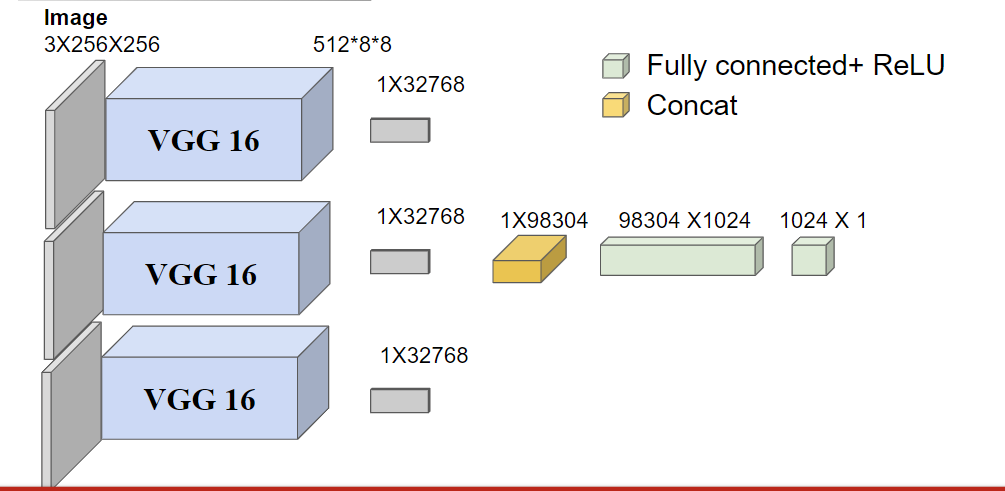

In [ ]:

'''
pretrained model VGG 16 AlexNet LeNet .... Transfer learning 
'''
import torch.nn.functional as F
from torch import nn
class Model_no_dp(nn.Module):
    def __init__(self):
        super(Model_no_dp, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.l1   =  nn.Linear(98304 ,1024)
        self.l2   =  nn.Linear(1024,1) # regression 이기 때문에 마지막 차원 1 
        self.VGG16 = model_pt.features


    def forward(self, top ,bot,shoes):
        top= self.VGG16(top)   #256*256
        bot = self.VGG16(bot)  
        shoes = self.VGG16(shoes) 
        N ,_,_,_ = top.size()

        top = top.reshape(N,-1)
        bot = bot.reshape(N,-1)
        shoes = shoes.reshape(N,-1)
        cat = torch.cat((top,bot,shoes),1)
        
        z = self.l1(cat)
        z = self.relu(z)
        z = self.l2(z)
        return z,top,bot,shoes,cat 
    


**label 수 확인**

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/캡스톤/label_and_path_withoutNaN")
df.iloc[:,7]

0       3426
1       1844
2        370
3       1265
4        323
        ... 
4285     308
4286      81
4287     148
4288     142
4289     176
Name: clean_view, Length: 4290, dtype: int64

**Train / Test 정의**

In [ ]:
groundtruth=[]
view_true_value=[]
top=[]
bot=[]
shoe=[]
def train(n_epochs,model,optimizer,criterion):
  rmse_train_history = []
  rmse_valid_history = []
  for epoch in range(1, n_epochs + 1):

    dataiter=iter(train_dataloader)
    u, p, s, label = dataiter.next()

        # clearing the Gradients of the model parameters
    optimizer.zero_grad()

        # prediction for training and validation set
    model.train()

    u=u.type(torch.cuda.FloatTensor)
    p=p.type(torch.cuda.FloatTensor)
    s=s.type(torch.cuda.FloatTensor)
    label=label.to(device)
    view_true_value.append(label)

    output_train,top_em,bot_em,shoes_em,_ = model(u,p,s)
    groundtruth.append(output_train)
    top.append(top_em)
    bot.append(bot_em)
    shoe.append(shoes_em)
        # computing the training and validation loss
    train_rmse = torch.sqrt(criterion(output_train, label)) #RMSE

    train_rmse.backward()
    optimizer.step()
    #validation
    model.eval()
    testiter=iter(test_dataloader)

    u,p,s ,y_test=testiter.next()

   

    u=u.type(torch.cuda.FloatTensor)
    p=p.type(torch.cuda.FloatTensor)
    s=s.type(torch.cuda.FloatTensor)   
    y_test=y_test.to(device)
           # prediction on testing dataset
   
    y_hat,top_em,bot_em,shoes_em,_= model(u,p,s)
    #y_hat=y_hat.detach().cpu().numpy()
    groundtruth.append(y_hat)
    top.append(top_em)
    bot.append(bot_em)
    shoe.append(shoes_em)
   
    _mse = criterion(y_hat,y_test)
    _valid_rmse = torch.sqrt(_mse)
    
    if epoch % 10== 0:
      print('Epoch :', epoch, '\t', 'train RMSE', round(train_rmse.item(), 3), 
            '\t', 'valid RMSE', round(_valid_rmse.item(), 3))
    rmse_train_history.append(train_rmse)
    rmse_valid_history.append(_valid_rmse)
  return rmse_train_history,rmse_valid_history

def test(n_epochs,model, optimizer,criterion):
  rmse_history = []
  for epoch in range(1, n_epochs + 1):
    model.eval()
    testiter=iter(test_dataloader)

    u,p,s ,y_test=testiter.next()

   

    u=u.type(torch.cuda.FloatTensor)
    p=p.type(torch.cuda.FloatTensor)
    s=s.type(torch.cuda.FloatTensor)   
    y_test=y_test.to(device)
           # prediction on testing dataset
   
    y_hat,top_em,bot_em,shoes_em,_= model(u,p,s)
    #y_hat=y_hat.detach().cpu().numpy()
    groundtruth.append(y_hat)
    top.append(top_em)
    bot.append(bot_em)
    shoe.append(shoes_em)
   
    _mse = criterion(y_hat,y_test)
    _test_rmse = torch.sqrt(_mse)
    if epoch % 10== 0:
      print('Epoch :', epoch, '\t',"RMSE =", round(_test_rmse.item(),3))
    rmse_history.append(_test_rmse)
  return rmse_history

**학습**


In [ ]:

from torch.utils.data import Dataset, DataLoader, random_split




custom_cloth = MU_normalized("/content/drive/MyDrive/캡스톤/label_and_path_withoutNaN")
dataset_size = len(custom_cloth)
train_size = int(dataset_size * 0.7)
test_size = dataset_size - train_size
train_dataset,  test_dataset = random_split(custom_cloth, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=True)


[0.73079691 0.65461002 0.45706487 ... 0.34437033 0.33928036 0.36568101]
['/content/drive/MyDrive/캡스톤/data/1'
 '/content/drive/MyDrive/캡스톤/data/3'
 '/content/drive/MyDrive/캡스톤/data/4' ...
 '/content/drive/MyDrive/캡스톤/data/16848'
 '/content/drive/MyDrive/캡스톤/data/16850'
 '/content/drive/MyDrive/캡스톤/data/16851']


In [ ]:
import random

def fix_seed(random_seed):
    """
    fix seed to control any randomness from a code 
    (enable stability of the experiments' results.)
    """
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

fix_seed(1)

In [ ]:
model_no_dp=Model_no_dp().to(device) 
dataset_size = len(custom_cloth)
train_dataset,  test_dataset = random_split(custom_cloth, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

criterion =torch.nn.MSELoss()
optimizer =torch.optim.SGD(model_no_dp.parameters(), lr=  0.001)

train_li,valid_li=train(200,model_no_dp,optimizer=optimizer,criterion=criterion)


Epoch : 10 	 train RMSE 0.365 	 valid RMSE 0.419
Epoch : 20 	 train RMSE 0.229 	 valid RMSE 0.277
Epoch : 30 	 train RMSE 0.166 	 valid RMSE 0.203
Epoch : 40 	 train RMSE 0.135 	 valid RMSE 0.171
Epoch : 50 	 train RMSE 0.158 	 valid RMSE 0.187
Epoch : 60 	 train RMSE 0.184 	 valid RMSE 0.111
Epoch : 70 	 train RMSE 0.11 	 valid RMSE 0.129
Epoch : 80 	 train RMSE 0.124 	 valid RMSE 0.122
Epoch : 90 	 train RMSE 0.124 	 valid RMSE 0.12
Epoch : 100 	 train RMSE 0.108 	 valid RMSE 0.13
Epoch : 110 	 train RMSE 0.131 	 valid RMSE 0.129
Epoch : 120 	 train RMSE 0.109 	 valid RMSE 0.104
Epoch : 130 	 train RMSE 0.099 	 valid RMSE 0.172
Epoch : 140 	 train RMSE 0.089 	 valid RMSE 0.132
Epoch : 150 	 train RMSE 0.08 	 valid RMSE 0.161
Epoch : 160 	 train RMSE 0.09 	 valid RMSE 0.129
Epoch : 170 	 train RMSE 0.089 	 valid RMSE 0.134
Epoch : 180 	 train RMSE 0.082 	 valid RMSE 0.119
Epoch : 190 	 train RMSE 0.107 	 valid RMSE 0.143
Epoch : 200 	 train RMSE 0.112 	 valid RMSE 0.129


In [3]:
gt=[]
for x_tensor in groundtruth:
  x_tensor=x_tensor.detach().cpu().numpy()
  for x in x_tensor:
    gt.append(x.item())

import csv 

with open('groundtruth.csv','w',encoding='utf8',newline='') as f: 
  write =csv.writer(f)

  write.writerows(f)

NameError: ignored

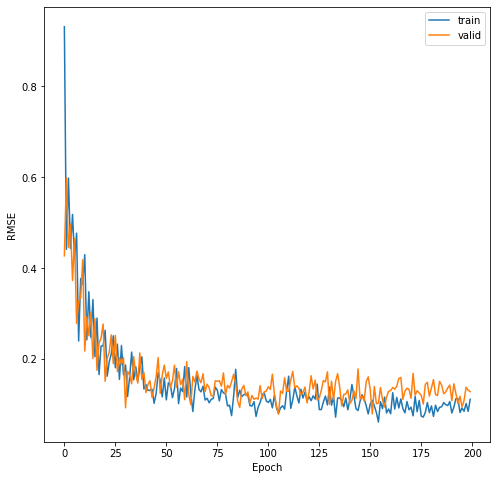

In [ ]:
#시각화
t_l=[]
for x in train_li:
  x=x.detach().cpu().numpy()
  t_l.append(x)

vd_l=[]
for x in valid_li:
  x=x.detach().cpu().numpy()
  vd_l.append(x)

fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
 
ax.plot(np.arange(200),t_l,label='train') ## 선그래프 생성
ax.plot(np.arange(200),vd_l,label='valid') 

ax.legend()

plt.xlabel("Epoch")
plt.ylabel("RMSE")

plt.show()

In [ ]:
#randomly show images 
import random
import os
import numpy as np
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
%matplotlib inline
path_list=df['img_path']
cloth_list=[]
for path in np.random.choice(path_list,5):
  u = path+'/U.jpg'
  p = path+'/P.jpg'
  s = path+'/S.jpg'
  if os.path.isfile(u):
      u_as_img =Image.open(u).convert("RGB")
      u_as_img =np.array(u_as_img)
  else :
      u_as_img =Image.new("RGB", (256, 256), (255, 255, 255))
      u_as_img =np.array(u_as_img)
  if os.path.isfile(p):
      p_as_img =Image.open(p).convert("RGB")
      p_as_img =np.array(p_as_img)
  else :
      p_as_img =Image.new("RGB", (256, 256), (255, 255, 255))
      p_as_img =np.array(p_as_img)
  if os.path.isfile(s):
      s_as_img =Image.open(s).convert("RGB")
      s_as_img =np.array(s_as_img)
  else :
      s_as_img =Image.new("RGB", (256, 256), (255, 255, 255))
      s_as_img =np.array(s_as_img)
  cloth_list.append(u_as_img)
  cloth_list.append(p_as_img)
  cloth_list.append(s_as_img)
print(cloth_list)

[array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]

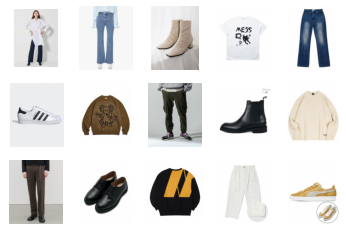

In [ ]:
for idx, x in enumerate(cloth_list):
  plt.subplot(3,5,idx+1)
  plt.imshow(x)
  plt.axis('off')
plt.show()

In [19]:
torch.save(model_no_dp.state_dict(), '/content/drive/MyDrive/캡스톤/model.pt')
torch.save(model_no_dp.state_dict(),'/content/drive/MyDrive/캡스톤/model.pkl')